In [1]:
import os, sys
import torch
from pathlib import Path
import numpy as np
import matplotlib
from matplotlib import cm
# matplotlib.use("agg")
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker


__file__ = os.path.dirname(os.path.realpath("__file__"))
root_dir = (Path(__file__).parent / "..").resolve()
lib_dir = (root_dir / "lib").resolve()
print("The root path: {:}".format(root_dir))
print("The library path: {:}".format(lib_dir))
assert lib_dir.exists(), "{:} does not exist".format(lib_dir)
if str(lib_dir) not in sys.path:
    sys.path.insert(0, str(lib_dir))

from datasets import SynAdaptiveEnv
from xlayers.super_core import SuperSequential, SuperMLPv1

The root path: /Users/xuanyidong/Desktop/AutoDL-Projects
The library path: /Users/xuanyidong/Desktop/AutoDL-Projects/lib


SynAdaptiveEnv(100/100 elements
amplitude=QuadraticFunction(y = 4.8680419921875 * x^2 + 3.565875291824341 * x + 0.9999021291732788),
)period_phase_shift=QuadraticFunction(y = 0.00021915265824645758 * x^2 + 0.9999573826789856 * x + -1.2333193808444776e-05)


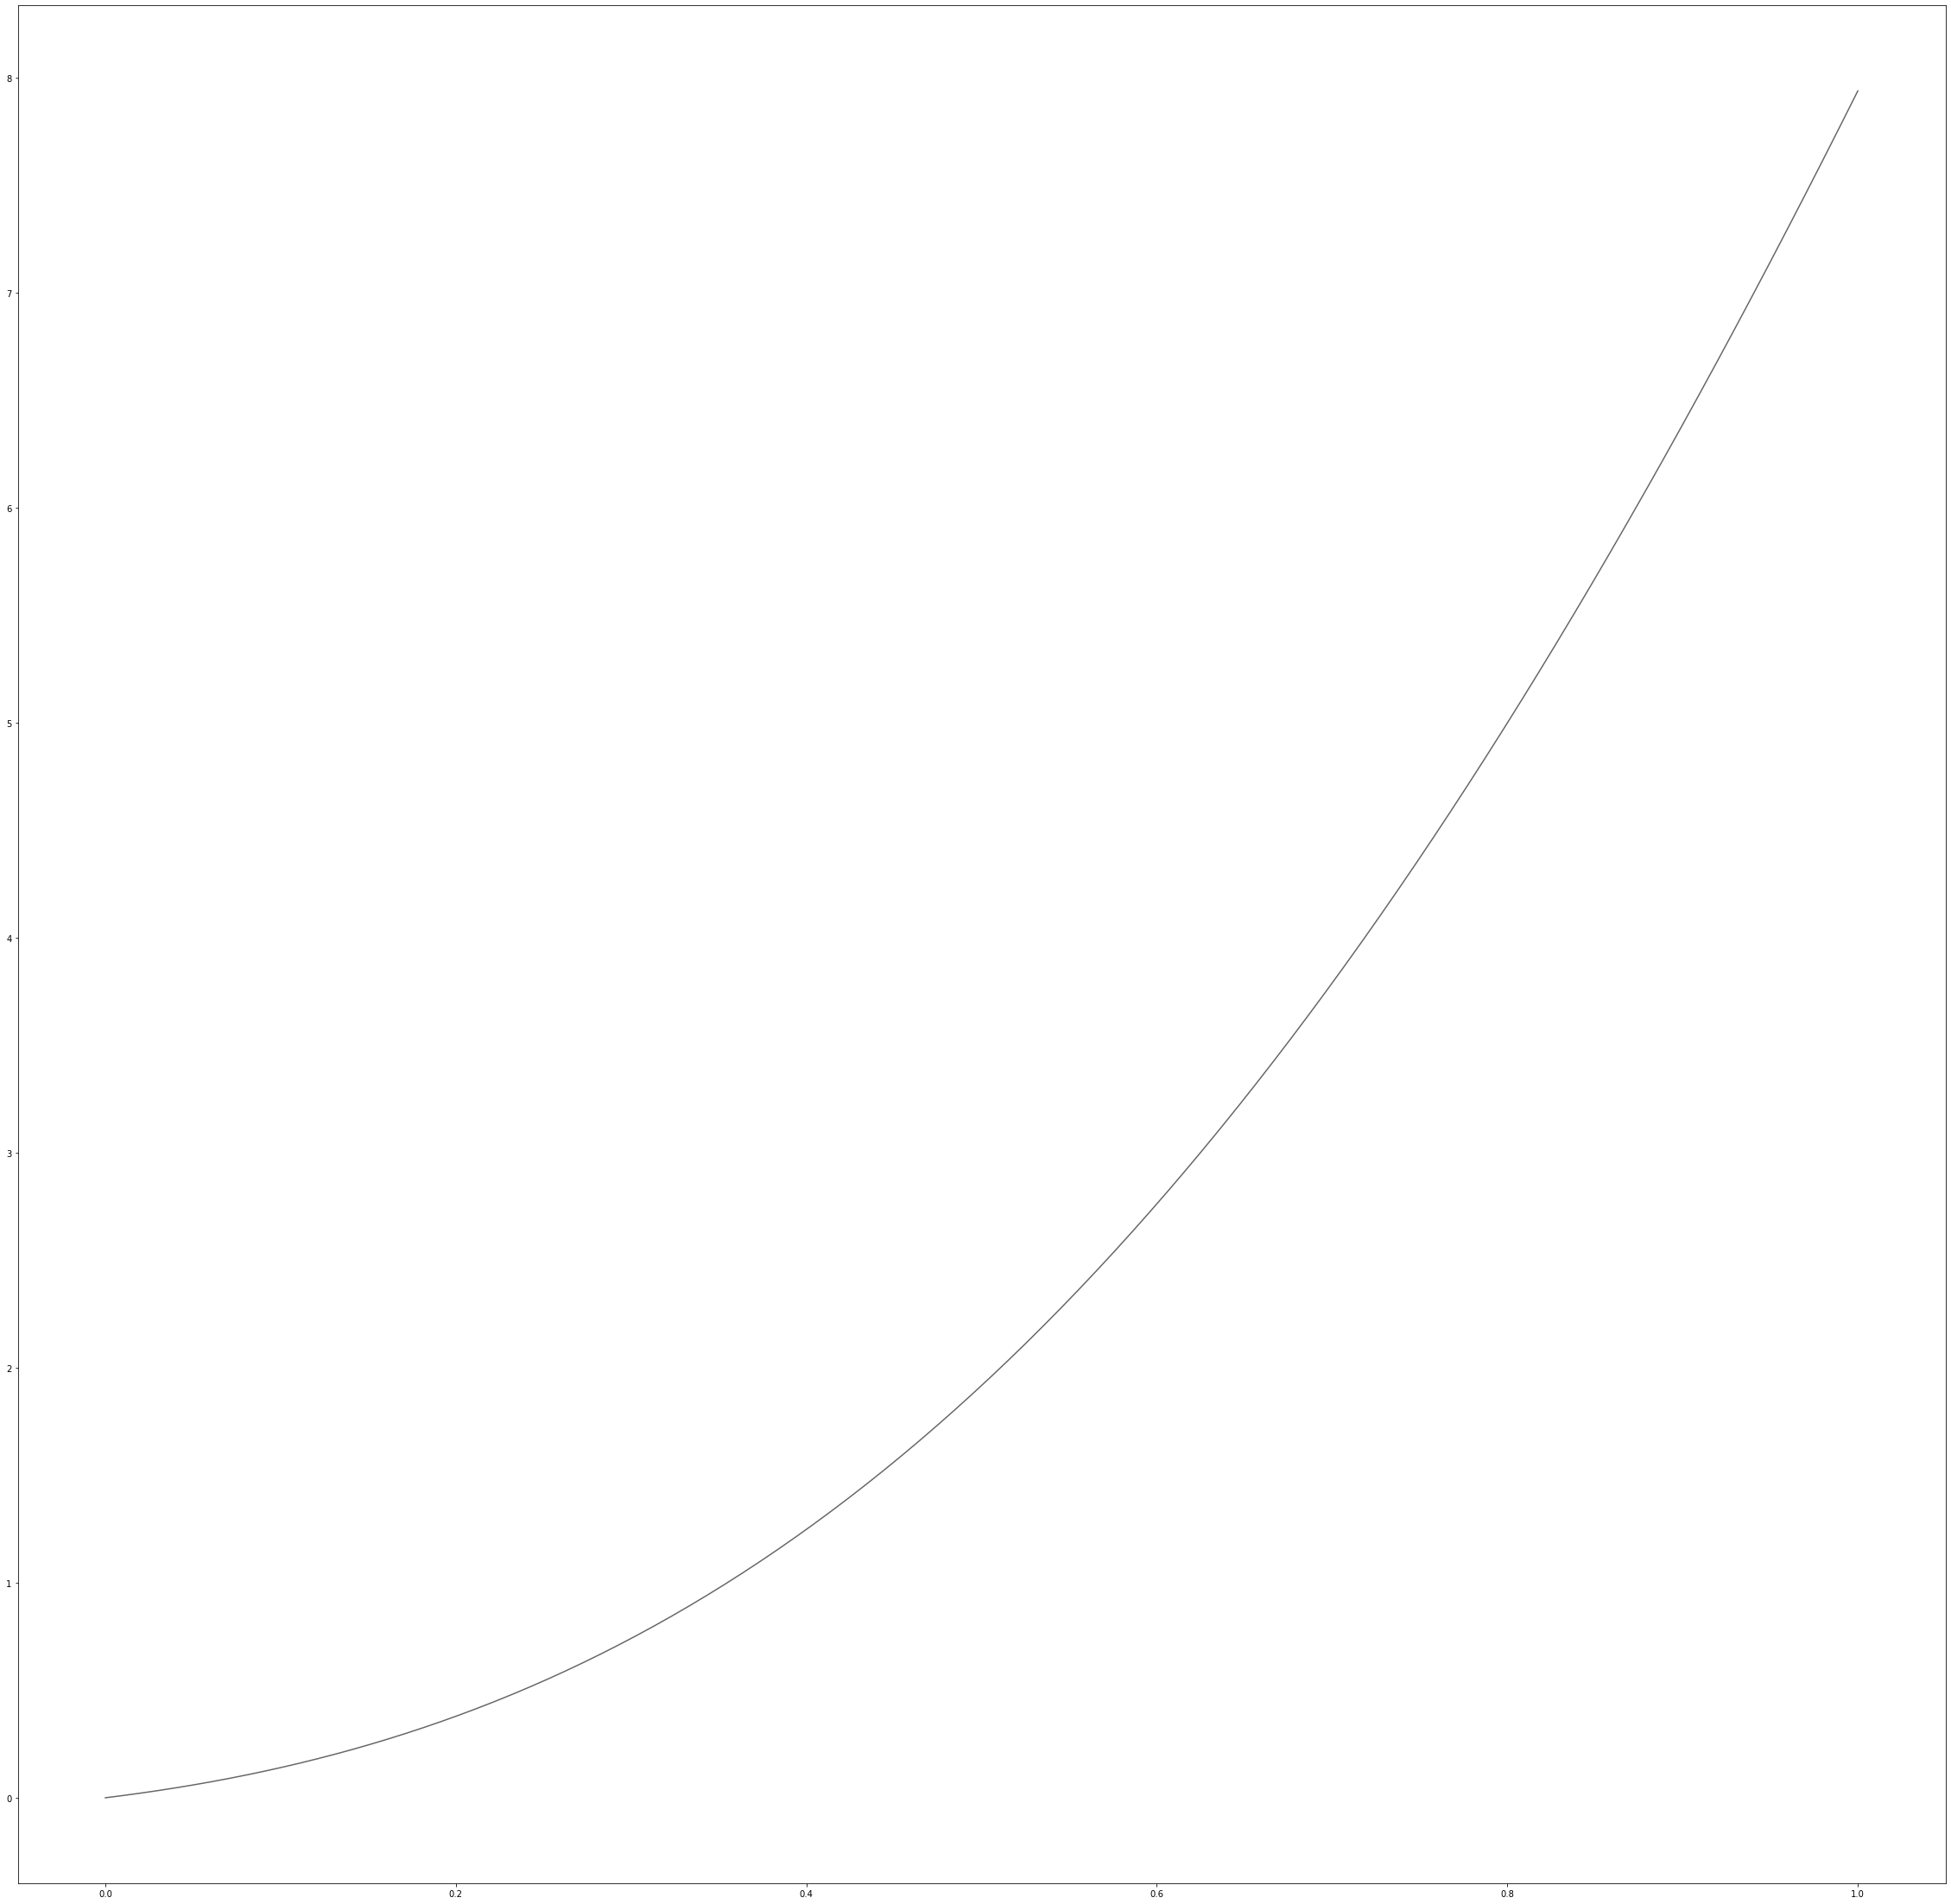

In [2]:
def visualize_q_func():
    # save_dir = (save_path / '..').resolve()
    # save_dir.mkdir(parents=True, exist_ok=True)
    
    dpi, width, height = 10, 400, 400
    figsize = width / float(dpi), height / float(dpi)
    LabelSize, LegendFontsize, font_gap = 40, 40, 5
    
    fig = plt.figure(figsize=figsize)
    
    dataset = SynAdaptiveEnv()
    print(dataset)
    xaxis, yaxis = [], []
    for idx, position, value in dataset:
        xaxis.append(position)
        yaxis.append(value)
    
    def draw_ax(cur_ax, xaxis, yaxis, xlabel, ylabel,
                alpha=0.1, color='k', linestyle='-', legend=None, plot_only=False):
        if legend is not None:
            cur_ax.plot(xaxis[:1], yaxis[:1], color=color, label=legend)
        
        if not plot_only:
            cur_ax.set_xlabel(xlabel, fontsize=LabelSize)
            cur_ax.set_ylabel(ylabel, rotation=0, fontsize=LabelSize)
            for tick in cur_ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(LabelSize - font_gap)
                tick.label.set_rotation(10)
            for tick in cur_ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(LabelSize - font_gap)
    
    cur_ax = fig.add_subplot(1, 1, 1)
    cur_ax.plot(xaxis, yaxis, color="k", linestyle="-", alpha=0.6, label=None)

    # fig.savefig(save_path, dpi=dpi, bbox_inches="tight", format="pdf")
    # plt.close("all")
    # plt.show()
visualize_q_func()

In [2]:
def optimize_fn(xs, ys, test_sets):
    xs = torch.FloatTensor(xs).view(-1, 1)
    ys = torch.FloatTensor(ys).view(-1, 1)
    
    model = SuperSequential(
        SuperMLPv1(1, 10, 20, torch.nn.ReLU),
        SuperMLPv1(20, 10, 1, torch.nn.ReLU)
    )
    optimizer = torch.optim.Adam(
        model.parameters(),
        lr=0.01, weight_decay=1e-4, amsgrad=True
    )
    for _iter in range(100):
        preds = model(ys)

        optimizer.zero_grad()
        loss = torch.nn.functional.mse_loss(preds, ys)
        loss.backward()
        optimizer.step()
        
    with torch.no_grad():
        answers = []
        for test_set in test_sets:
            test_set = torch.FloatTensor(test_set).view(-1, 1)
            preds = model(test_set).view(-1).numpy()
            answers.append(preds.tolist())
    return answers

def f(x):
    return np.cos( 0.5 * x + x * x)

def get_data(mode):
    dataset = SynAdaptiveEnv(mode=mode)
    times, xs, ys = [], [], []
    for i, (_, t, x) in enumerate(dataset):
        times.append(t)
        xs.append(x)
    dataset.set_transform(f)
    for i, (_, _, y) in enumerate(dataset):
        ys.append(y)
    return times, xs, ys

def visualize_syn(save_path):
    save_dir = (save_path / '..').resolve()
    save_dir.mkdir(parents=True, exist_ok=True)
    
    dpi, width, height = 40, 2000, 900
    figsize = width / float(dpi), height / float(dpi)
    LabelSize, LegendFontsize, font_gap = 40, 40, 5
    
    fig = plt.figure(figsize=figsize)
    
    times, xs, ys = get_data(None)
    
    def draw_ax(cur_ax, xaxis, yaxis, xlabel, ylabel,
                alpha=0.1, color='k', linestyle='-', legend=None, plot_only=False):
        if legend is not None:
            cur_ax.plot(xaxis[:1], yaxis[:1], color=color, label=legend)
        cur_ax.plot(xaxis, yaxis, color=color, linestyle=linestyle, alpha=alpha, label=None)
        if not plot_only:
            cur_ax.set_xlabel(xlabel, fontsize=LabelSize)
            cur_ax.set_ylabel(ylabel, rotation=0, fontsize=LabelSize)
            for tick in cur_ax.xaxis.get_major_ticks():
                tick.label.set_fontsize(LabelSize - font_gap)
                tick.label.set_rotation(10)
            for tick in cur_ax.yaxis.get_major_ticks():
                tick.label.set_fontsize(LabelSize - font_gap)
    
    cur_ax = fig.add_subplot(2, 1, 1)
    draw_ax(cur_ax, times, xs, "time", "x", alpha=1.0, legend=None)

    cur_ax = fig.add_subplot(2, 1, 2)
    draw_ax(cur_ax, times, ys, "time", "y", alpha=0.1, legend="ground truth")
    
    train_times, train_xs, train_ys = get_data("train")
    draw_ax(cur_ax, train_times, train_ys, None, None, alpha=1.0, color='r', legend=None, plot_only=True)
    
    valid_times, valid_xs, valid_ys = get_data("valid")
    draw_ax(cur_ax, valid_times, valid_ys, None, None, alpha=1.0, color='g', legend=None, plot_only=True)
    
    test_times, test_xs, test_ys = get_data("test")
    draw_ax(cur_ax, test_times, test_ys, None, None, alpha=1.0, color='b', legend=None, plot_only=True)
    
    # optimize MLP models
#     [train_preds, valid_preds, test_preds] = optimize_fn(train_xs, train_ys, [train_xs, valid_xs, test_xs])
#     draw_ax(cur_ax, train_times, train_preds, None, None,
#             alpha=1.0, linestyle='--', color='r', legend="MLP", plot_only=True)
#     import pdb; pdb.set_trace()
#     draw_ax(cur_ax, valid_times, valid_preds, None, None,
#             alpha=1.0, linestyle='--', color='g', legend=None, plot_only=True)
#     draw_ax(cur_ax, test_times, test_preds, None, None,
#             alpha=1.0, linestyle='--', color='b', legend=None, plot_only=True)

    plt.legend(loc=1, fontsize=LegendFontsize)

    fig.savefig(save_path, dpi=dpi, bbox_inches="tight", format="pdf")
    plt.close("all")
    # plt.show()

In [3]:
# Visualization
# home_dir = Path.home()
# desktop_dir = home_dir / 'Desktop'
# print('The Desktop is at: {:}'.format(desktop_dir))
# visualize_syn(desktop_dir / 'tot-synthetic-v0.pdf')

The Desktop is at: /Users/xuanyidong/Desktop
